In [1]:
import os
import sys
from collections import OrderedDict
sys.path.append("../..")
import spatialpy
spatialpy.__file__
import matplotlib.pyplot as plt
import numpy
%load_ext autoreload
%autoreload 2

In [2]:
class Teleport(spatialpy.BoundaryCondition):
    def expression(self):
        return """
        if(isnan(me->x[0]) || me->x[0] > system->xhi){
            me->x[0] = system->xlo + 0.55;
        }
        if(isnan(me->x[1]) || me->x[1] > system->yhi){
            me->x[1] = system->yhi;
        }
        me->x[2] = 0;
        me->rho = 250.0;
        """

In [3]:
class HardFloor(spatialpy.BoundaryCondition):
    def expression(self):
        return """
        if(me->x[1] < 0.4){
            me->x[1] = 0.5;
            me->v[1] = 0.0;
        }
        """

In [4]:
class HardWall(spatialpy.BoundaryCondition):
    def expression(self):
        return """
        if(me->x[0] < 1){
            me->x[0] = system->xlo + 0.5;
            me->v[1] = 0.0;
        }
        """

In [28]:
class weir(spatialpy.Model):
    def __init__(self, model_name="weir_aka_backward_facing_step"):
        spatialpy.Model.__init__(self, model_name)

        xmax = 50
        ymax = 10
        deltax = 0.2

        # Construct mesh for backward facing step
        self.mesh = spatialpy.Mesh(0, xlim=(0,xmax), ylim=(0,ymax), zlim=(0,0), gravity=[0,-1,0])
        for x in numpy.arange(start=0, stop=xmax+deltax, step=deltax):
            for y in numpy.arange(start=0, stop=ymax+deltax, step=deltax):
                # Top and bottom
                if y == 0 or y == 10:
                    self.mesh.add_point([x,y,0], type=1, mass=10.0, vol=1.0, nu=1.0, fixed=True)
                # Water
                elif y > 1.5 and y < 8 and x > 1.5 and x < 8:
                    self.mesh.add_point([x,y,0], type=2, mass=10.0, vol=1.0, nu=1.0, fixed=False)
                # Step
                elif x >= 10 and x <= 15 and y > 0 and y < 5:
                    self.mesh.add_point([x,y,0], type=1, mass=10.0, vol=1.0, nu=1.0, fixed=True)
                # Walls 
                elif x == 0 or x == 50:
                    self.mesh.add_point([x,y,0], type=1, mass=10.0, vol=1.0, nu=1.0, fixed=True)


        # Teleport particles back to start to simulate flow
        self.add_boundary_condition(Teleport())
        #self.add_boundary_condition(HardFloor())
        #self.add_boundary_condition(HardWall())
        # Velocity
        #self.add_boundary_condition(spatialpy.BoundaryCondition(
        #    type_id=2,
        #    property = 'v',
        #   value    = [0.005, 0.0, 0.0] 
        #))

        self.staticDomain = False  # allow particles to move

        # Define time parameters
        self.timestep_size = 1e-3  # timestep size
        #self.num_timesteps = 50000    # number of timesteps
        #self.num_timesteps = 200000    # number of timesteps
        #self.output_freq = 400      # frequency of outputting results
        self.num_timesteps = 500    # number of timesteps
        self.output_freq = 5      # frequency of outputting results
        

In [29]:
model = weir()

In [36]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()

CPU times: user 418 ms, sys: 3.43 ms, total: 421 ms
Wall time: 19 s


In [39]:
%time result = sol.run()

ERROR: nan/inf detected!!!
id=66
x[0]=5.500000e-01
x[1]=1.000000e+01
x[2]=0.000000e+00
v[0]=inf
v[1]=inf
v[2]=-inf
vt[0]=0.000000e+00
vt[1]=0.000000e+00
vt[2]=0.000000e+00
F[0]=-inf
F[1]=-inf
F[2]=inf
Fbp[0]=2.730640e+121
Fbp[1]=3.291561e+121
Fbp[2]=0.000000e+00
old_x[0]=5.500000e-01
old_x[1]=1.000000e+01
old_x[2]=0.000000e+00
old_v[0]=-1.126868e+119
old_v[1]=1.635646e+119
old_v[2]=-1.085326e+113
sys->current_step=50
sys->dt=1.000000e-03
solver_cmd = cd /tmp/spatialpy_result_x7cb9fcy;/tmp/spatialpy_build_bm7vf8du/ssa_sdpd


SimulationError: Solver execution failed, return code = 1

In [13]:
def mpl_plot_property(t_ndx=0):
        import matplotlib.pyplot as plt
        
        points, data = result.read_step(t_ndx)

        d = data["type"]

        plt.figure(figsize=(6.4, 4.8))
        plt.scatter(points[:,0],points[:,1], c=d)
        plt.axis('scaled')
        #plt.colorbar()
        plt.title("t={0}".format(t_ndx))
        plt.grid(linestyle='', linewidth=1)
        plt.plot()
        return

In [14]:
timespan = []
time_vals = []
for i,t in enumerate(result.get_timespan()):
    time_vals.append(t)
    timespan.append(i)
print(timespan)
print(time_vals)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.17500000000000002, 0.18, 0.185, 0.19, 0.195, 0.2, 0.20500000000000002, 0.21, 0.215, 0.22, 0.225, 0.23, 0.23500000000000001, 0.24, 0.245, 0.25, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.28500000000000003, 0.29, 0.295, 0.3, 0.305, 0.31, 0.315, 0.32, 0.325, 0.33, 0.335, 0.34, 0.34500000000000003, 0.35000000000000003, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38, 0.385, 0.39, 0.395, 0.

t=9 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output45.vtk'
t=10 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output50.vtk'
t=11 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output55.vtk'
t=12 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output60.vtk'
t=13 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output65.vtk'
t=14 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output70.vtk'
t=15 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output75.vtk'
t=16 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output80.vtk'
t=17 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output85.vtk'
t=18 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output90.vtk'
t=19 [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output95.vtk'
t=20 [Errno 2] No such file or di

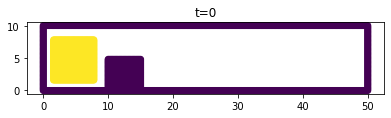

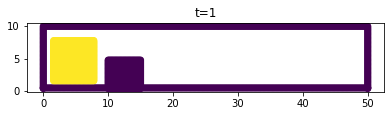

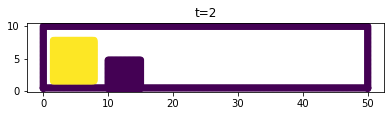

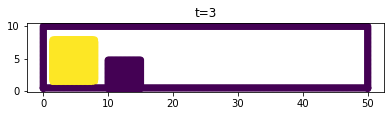

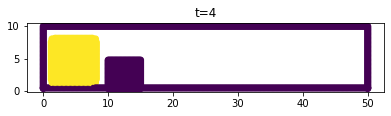

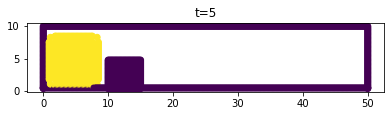

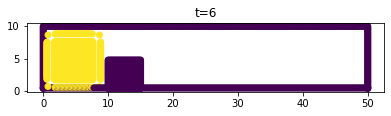

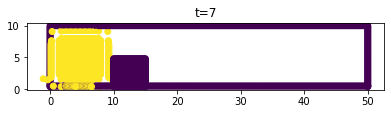

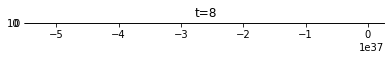

In [15]:
for i in timespan:
    try:
        mpl_plot_property(i)
    except Exception as e:
        print("t={0} {1}".format(i,e))


In [24]:
?result.plot_property

In [26]:
for i in timespan:
    result.plot_property('v',t_ndx=i,p_ndx=1,title="t={0}".format(i))

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/spatialpy_result_wblh14yd/output45.vtk'